This workbook is divided into several parts, KerasTuner API is not running now to save time, working example is here https://www.kaggle.com/code/aikhmelnytskyy/gislr-tf-on-the-shoulders-ensamble?scriptVersionId=121543912

# Hi to all! In this notebook, I have prepared an example of how to use the KerasTuner API(https://keras.io/api/keras_tuner/)
# to find model hyperparameters.
# I took this wonderful notebook as a basis: https://www.kaggle.com/code/roberthatch/gislr-lb-0-63-on-the-shoulders
# I added the code from this notebook: https://www.kaggle.com/code/dschettler8845/gislr-how-to-ensemble
# In version 8, I added the code from this notebook: https://www.kaggle.com/code/aleksandrkruchinin/tflite-ensemble
# In version 9, I added the code from this notebook: https://www.kaggle.com/code/clemchris/asl-sign-detection-pytorch-lightning
# Please don't forget to upvote for all notebooks
# So let's start

# GISLR [LB 0.63]: On the Shoulders of Giants
This notebook is built on top of the great work from the community! In particular, this notebook is copied directly from Darien's excellent work [here][1], and the features are loaded from my notebook [here][2], and that notebook is directly based off of the format [here][3].

This notebook is going public to celebrate my first ever public LB first place! Fun!

In this notebook, the main updates are:
1. Adding the time dimension! Finally, right? There's a 0.58 notebook [here][4] that STILL is just flat mean + std, so I hardly think 0.63 is nearing the limit of what we can achieve. Check out the [features notebook][2], I do two different techniques for the time dimension, resize is one, and padding into a multiple of 3, and then taking mean and std of each third of the data is the other. It took some doing to implement them within the TFLite format/restrictions, so I hope it serves as a useful resource for others!
2. Just small hyperparameter adjustments.
3. Oh, and drop face, drop pose, add lips. But refer to the features notebook for the precise details.

# More Credits
Thanks to many Kagglers who have shared ideas. Lonnie's notebook [here][5] helped me and pretty much everyone as we were struggling to figure out this TFLite Model competition format. Andrew helped give suggestions on some of my questions on the discussion page.

[1]: https://www.kaggle.com/code/dschettler8845/gislr-learn-eda-baseline
[2]: https://www.kaggle.com/code/roberthatch/gislr-feature-data-on-the-shoulders
[3]: https://www.kaggle.com/code/mayukh18/gislr-feature-data
[4]: https://www.kaggle.com/code/medali1992/gislr-nn-arcface-baseline
[5]: https://www.kaggle.com/code/lonnieqin/isolated-sign-language-recognition-with-dnn

<br><br>
# MOTIVATION
**\#OpenToWork**

After 9 years as a Silicon Firmware Engineer at Intel, I am now looking for my next career opportunity. Naturally I am especially interested in Machine Learning opportunities.

In this notebook, my goals are to:
* Demonstrate my core strengths. Soft skills like problem solving, communication, and passion.
* Build up my knowledge skills. I love machine learning and, in particular, love to optimize anything and everything. In this notebook, I explore TensorFlow and Neural Networks.
* Continue to build on previous Kaggle successes.

**LinkedIn:** https://www.linkedin.com/in/robhatch/

**Kaggle:** https://www.kaggle.com/roberthatch

In [1]:
import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

# IMPORTS

In [2]:
print("\n... PIP INSTALLS STARTING ...\n")
!pip install -q --upgrade tensorflow-io
try:
    import mediapipe as mp
except:
    !pip install -q mediapipe
    import mediapipe as mp
print("\n... PIP INSTALLS COMPLETE ...\n")

!pip install lion-tf
print("\n... IMPORTS STARTING ...\n")
print("\n\tVERSION INFORMATION")
# Competition Specific Imports (You'll see why we need these later)
# mediapipe above

# Machine Learning and Data Science Imports (basics)
import tensorflow as tf; print(f"\t\t– TENSORFLOW VERSION: {tf.__version__}");
import tensorflow_io as tfio; print(f"\t\t– TENSORFLOW-IO VERSION: {tfio.__version__}");
import pandas as pd; pd.options.mode.chained_assignment = None; pd.set_option('display.max_columns', None);
import numpy as np; print(f"\t\t– NUMPY VERSION: {np.__version__}");
import sklearn; print(f"\t\t– SKLEARN VERSION: {sklearn.__version__}");

# Built-In Imports (mostly don't worry about these)
from kaggle_datasets import KaggleDatasets
from collections import Counter
from datetime import datetime
from zipfile import ZipFile
from glob import glob
import Levenshtein
import warnings
import requests
import hashlib
import imageio
import IPython
import sklearn
import urllib
import zipfile
import pickle
import random
import shutil
import string
import json
import math
import time
import gzip
import ast
import sys
import io
import os
import gc
import re

def seed_it_all(seed=7):
    """ Attempt to be Reproducible """
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_it_all()

print("\n\n... IMPORTS COMPLETE ...\n")


... PIP INSTALLS STARTING ...

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
tensorflow-transform 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
tensorflow-serving-api 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.

... PIP INSTALLS COMPLETE ...

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.9 MB/s eta 0:00:0000:010:01
  Created wheel for lion-tf: filename=lion_tf-0.0.1-py3-none-any.whl size=3128 sha256=589e40c8bc644946befbe723e3277bfb84a000d64479f5d77c43e1bed174b611
  Stored in directory: /root/.cache/pip/wheels/b2/8a/8d/9a0be2470440010954105496dd04d09502b09b51191fd4b9a2
Successfully built lion-tf
  Attempting uninstall: proto

# SETUP

### HELPER FUNCTIONS

In [3]:
def read_json_file(file_path):
    try:
        # Open the file and load the JSON data into a Python object
        with open(file_path, 'r') as file:
            json_data = json.load(file)
        return json_data
    except FileNotFoundError:
        # Raise an error if the file path does not exist
        raise FileNotFoundError(f"File not found: {file_path}")
    except ValueError:
        # Raise an error if the file does not contain valid JSON data
        raise ValueError(f"Invalid JSON data in file: {file_path}")


ROWS_PER_FRAME = 543  # number of landmarks per frame
def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

### LOAD DATA

In [4]:
# Define the path to the root data directory
DATA_DIR         = "/kaggle/input/asl-signs"

print("\n... BASIC DATA SETUP STARTING ...\n")
print("\n\n... LOAD TRAIN DATAFRAME FROM CSV FILE ...\n")

train_df = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
train_df["path"] = DATA_DIR+"/"+train_df["path"]
display(train_df)

print("\n\n... LOAD SIGN TO PREDICTION INDEX MAP FROM JSON FILE ...\n")
s2p_map = {k.lower():v for k,v in read_json_file(os.path.join(DATA_DIR, "sign_to_prediction_index_map.json")).items()}
p2s_map = {v:k for k,v in read_json_file(os.path.join(DATA_DIR, "sign_to_prediction_index_map.json")).items()}
encoder = lambda x: s2p_map.get(x.lower())
decoder = lambda x: p2s_map.get(x)
print(s2p_map)



... BASIC DATA SETUP STARTING ...



... LOAD TRAIN DATAFRAME FROM CSV FILE ...



,path,participant_id,sequence_id,sign
0,/kaggle/input/asl-signs/train_landmark_files/2...,26734,1000035562,blow
1,/kaggle/input/asl-signs/train_landmark_files/2...,28656,1000106739,wait
2,/kaggle/input/asl-signs/train_landmark_files/1...,16069,100015657,cloud
3,/kaggle/input/asl-signs/train_landmark_files/2...,25571,1000210073,bird
4,/kaggle/input/asl-signs/train_landmark_files/6...,62590,1000240708,owie
...,...,...,...,...
94472,/kaggle/input/asl-signs/train_landmark_files/5...,53618,999786174,white
94473,/kaggle/input/asl-signs/train_landmark_files/2...,26734,999799849,have
94474,/kaggle/input/asl-signs/train_landmark_files/2...,25571,999833418,flower
94475,/kaggle/input/asl-signs/train_landmark_files/2...,29302,999895257,room




... LOAD SIGN TO PREDICTION INDEX MAP FROM JSON FILE ...

{'tv': 0, 'after': 1, 'airplane': 2, 'all': 3, 'alligator': 4, 'animal': 5, 'another': 6, 'any': 7, 'apple': 8, 'arm': 9, 'aunt': 10, 'awake': 11, 'backyard': 12, 'bad': 13, 'balloon': 14, 'bath': 15, 'because': 16, 'bed': 17, 'bedroom': 18, 'bee': 19, 'before': 20, 'beside': 21, 'better': 22, 'bird': 23, 'black': 24, 'blow': 25, 'blue': 26, 'boat': 27, 'book': 28, 'boy': 29, 'brother': 30, 'brown': 31, 'bug': 32, 'bye': 33, 'callonphone': 34, 'can': 35, 'car': 36, 'carrot': 37, 'cat': 38, 'cereal': 39, 'chair': 40, 'cheek': 41, 'child': 42, 'chin': 43, 'chocolate': 44, 'clean': 45, 'close': 46, 'closet': 47, 'cloud': 48, 'clown': 49, 'cow': 50, 'cowboy': 51, 'cry': 52, 'cut': 53, 'cute': 54, 'dad': 55, 'dance': 56, 'dirty': 57, 'dog': 58, 'doll': 59, 'donkey': 60, 'down': 61, 'drawer': 62, 'drink': 63, 'drop': 64, 'dry': 65, 'dryer': 66, 'duck': 67, 'ear': 68, 'elephant': 69, 'empty': 70, 'every': 71, 'eye': 72, 'face': 73, '

# PREPROCESSING

The preprocessing cells need to match the same cells from the feature generation notebook

## Configuration

In [5]:
DROP_Z = False

NUM_FRAMES1 = 15
SEGMENTS = 3

LEFT_HAND_OFFSET = 468
POSE_OFFSET = LEFT_HAND_OFFSET+21
RIGHT_HAND_OFFSET = POSE_OFFSET+33

## average over the entire face, and the entire 'pose'
averaging_sets = [[0, 468], [POSE_OFFSET, 33]]

lip_landmarks = [61, 185, 40, 39, 37,  0, 267, 269, 270, 409,
                 291,146, 91,181, 84, 17, 314, 405, 321, 375, 
                 78, 191, 80, 81, 82, 13, 312, 311, 310, 415, 
                 95, 88, 178, 87, 14,317, 402, 318, 324, 308]
left_hand_landmarks = list(range(LEFT_HAND_OFFSET, LEFT_HAND_OFFSET+21))
right_hand_landmarks = list(range(RIGHT_HAND_OFFSET, RIGHT_HAND_OFFSET+21))

point_landmarks = [item for sublist in [lip_landmarks, left_hand_landmarks, right_hand_landmarks] for item in sublist]

LANDMARKS1 = len(point_landmarks) + len(averaging_sets)
print(LANDMARKS1)
if DROP_Z:
    INPUT_SHAPE1 = (NUM_FRAMES1,LANDMARKS1*2)
else:
    INPUT_SHAPE1 = (NUM_FRAMES1,LANDMARKS1*3)

FLAT_INPUT_SHAPE1 = (INPUT_SHAPE1[0] + 2 * (SEGMENTS + 1)) * INPUT_SHAPE1[1]
    

84


## Helper Functions

In [6]:
def tf_nan_mean(x, axis=0):
    return tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), x), axis=axis) / tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), tf.ones_like(x)), axis=axis)

def tf_nan_std(x, axis=0):
    d = x - tf_nan_mean(x, axis=axis)
    return tf.math.sqrt(tf_nan_mean(d * d, axis=axis))

def flatten_means_and_stds1(x, axis=0):
    # Get means and stds
    x_mean = tf_nan_mean(x, axis=0)
    x_std  = tf_nan_std(x,  axis=0)

    x_out = tf.concat([x_mean, x_std], axis=0)
    x_out = tf.reshape(x_out, (1, INPUT_SHAPE1[1]*2))
    x_out = tf.where(tf.math.is_finite(x_out), x_out, tf.zeros_like(x_out))
    return x_out


## TensorFlow Feature Preprocessing Layer

In [7]:
class FeatureGen(tf.keras.layers.Layer):
    def __init__(self):
        super(FeatureGen, self).__init__()
    
    def call(self, x_in):
        if DROP_Z:
            x_in = x_in[:, :, 0:2]
        x_list = [tf.expand_dims(tf_nan_mean(x_in[:, av_set[0]:av_set[0]+av_set[1], :], axis=1), axis=1) for av_set in averaging_sets]
        x_list.append(tf.gather(x_in, point_landmarks, axis=1))
        x = tf.concat(x_list, 1)

        x_padded = x
        for i in range(SEGMENTS):
            p0 = tf.where( ((tf.shape(x_padded)[0] % SEGMENTS) > 0) & ((i % 2) != 0) , 1, 0)
            p1 = tf.where( ((tf.shape(x_padded)[0] % SEGMENTS) > 0) & ((i % 2) == 0) , 1, 0)
            paddings = [[p0, p1], [0, 0], [0, 0]]
            x_padded = tf.pad(x_padded, paddings, mode="SYMMETRIC")
        x_list = tf.split(x_padded, SEGMENTS)
        x_list = [flatten_means_and_stds1(_x, axis=0) for _x in x_list]

        x_list.append(flatten_means_and_stds1(x, axis=0))
        
        ## Resize only dimension 0. Resize can't handle nan, so replace nan with that dimension's avg value to reduce impact.
        x = tf.image.resize(tf.where(tf.math.is_finite(x), x, tf_nan_mean(x, axis=0)), [NUM_FRAMES1, LANDMARKS1])
        x = tf.reshape(x, (1, INPUT_SHAPE1[0]*INPUT_SHAPE1[1]))
        x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)
        x_list.append(x)
        x = tf.concat(x_list, axis=1)
        return x

print(FeatureGen()(tf.keras.Input((543, 3), dtype=tf.float32, name="inputs")))
FeatureGen()(load_relevant_data_subset(train_df.path[0]))

KerasTensor(type_spec=TensorSpec(shape=(1, 5796), dtype=tf.float32, name=None), name='feature_gen/concat_5:0', description="created by layer 'feature_gen'")


<tf.Tensor: shape=(1, 5796), dtype=float32, numpy=
array([[ 5.18924236e-01,  3.42620254e-01,  1.48732506e-05, ...,
         6.35599867e-02,  5.70323110e-01, -1.20788895e-01]], dtype=float32)>

# TRAIN

In [8]:
## Hyperparameters
BATCH_SIZE = 128
VAL_PCT = 0.1
LEARNING_RATE = 0.000333
LR_PATIENCE = 2
LR_REDUCTION_FACTOR = 0.8
EPOCHS = 100

STARTING_LAYER_SIZE = 1024
DROPOUTS = [0.4, 0.4]


In [9]:
train_x    = np.load("/kaggle/input/gislr-feature-data-on-the-shoulders/feature_data.npy").astype(np.float32)
train_y    = np.load("/kaggle/input/gislr-feature-data-on-the-shoulders/feature_labels.npy").astype(np.uint8)
print(train_x.shape, train_y.shape)
if DROP_Z:
    train_x = np.reshape(train_x, [train_x.shape[0], -1, 3])
    train_x = train_x[:, :, 0:2]
    train_x = np.reshape(train_x, [train_x.shape[0], -1])
    print(train_x.shape, train_y.shape)

N_TOTAL = train_x.shape[0]
FLAT_FRAME_SHAPE = train_x.shape[1]
assert(FLAT_FRAME_SHAPE == FLAT_INPUT_SHAPE1)
N_VAL   = int(N_TOTAL*VAL_PCT)
N_TRAIN = N_TOTAL-N_VAL

#random_idxs = random.sample(range(N_TOTAL), N_TOTAL)
#train_idxs, val_idxs = np.array(random_idxs[:N_TRAIN]), np.array(random_idxs[N_TRAIN:])

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5)
fold=0
for i, (train_index, test_index) in enumerate(skf.split(train_x,train_y)):
    print(f"Fold {i}:")
    if i==fold:
        #print(train_index)
        val_x_fold, val_y_fold = train_x[test_index], train_y[test_index]
        train_x_fold, train_y_fold = train_x[train_index], train_y[train_index]

train_x_fold.shape


(94477, 5796) (94477,)
Fold 0:
Fold 1:
Fold 2:
Fold 3:
Fold 4:


(75581, 5796)

Importing kerastuner.tuners

In [10]:

from kerastuner.tuners import RandomSearch, BayesianOptimization
from lion_tf import Lion

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  """Entry point for launching an IPython kernel.


In [11]:
def fc_block(inputs, output_channels, dropout=0.2, activation="gelu"):
    x = tf.keras.layers.Dense(output_channels)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation)(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    return x
def build_model(hp):
    
    
    #Here we set the hyperparameters for the search, this is just a basic example:    
    STARTING_LAYER_SIZE = hp.Int(name="STARTING_LAYER_SIZE", min_value=1426, max_value=1554, step=32)
    dropout = [hp.Float(name="dropout1", min_value=0.24, max_value=0.40, step=0.02),   
               hp.Float(name="dropout2", min_value=0.24, max_value=0.40, step=0.02)]
    DROPOUTS_len= 2#hp.Int(name="dropouts_len", min_value=2, max_value=5, step=1)
    hp_activation = hp.Choice('hp_activation', values=["gelu", "relu"])
    hp_learning_rate = hp.Choice('hp_learning_rate', values=[LEARNING_RATE,LEARNING_RATE*0.7, LEARNING_RATE*0.9])
    
    hp_optimizer = hp.Choice('optimizer', values=['adam'])

    if hp_optimizer == 'lion':
        optimizer = Lion(hp_learning_rate)
    elif hp_optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(hp_learning_rate)
    def get_model(n_labels=250, init_fc=STARTING_LAYER_SIZE, flat_frame_len=FLAT_FRAME_SHAPE):
        _inputs = tf.keras.layers.Input(shape=(flat_frame_len,))
        x = _inputs

        # Define layers
        
        
        for i in range(DROPOUTS_len):
            x = fc_block(
                x, output_channels=init_fc//(2**i), 
                dropout=dropout[i]
            )

        # Define output layer
        _outputs = tf.keras.layers.Dense(n_labels, activation="softmax")(x)

        # Build the model
        model = tf.keras.models.Model(inputs=_inputs, outputs=_outputs)
        return model

    model = get_model()
    model.compile(optimizer, "sparse_categorical_crossentropy", metrics="acc")
    model.summary()
    return model
    #tf.keras.utils.plot_model(model)

In [12]:
#strategy = tf.distribute.MirroredStrategy()
tuner = BayesianOptimization(
    build_model,
    objective='val_acc',
    max_trials=20,
    executions_per_trial=1,
    directory='/',
    project_name='asl',
    #distribution_strategy=strategy
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5796)]            0         
                                                                 
 dense (Dense)               (None, 1426)              8266522   
                                                                 
 batch_normalization (BatchN  (None, 1426)             5704      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 1426)              0         
                                                                 
 dropout (Dropout)           (None, 1426)              0         
                                                                 
 dense_1 (Dense)             (None, 713)               1017451   
                                                             

In [13]:
!mkdir models
cb_list = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(patience=LR_PATIENCE, factor=LR_REDUCTION_FACTOR, verbose=1)
]
#history = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=EPOCHS, callbacks=cb_list, batch_size=BATCH_SIZE)
#model.save("./models/asl_model")

In [14]:
#We are looking for hyperparameters. Note that I only use 10 epochs, the number of epochs can be increased
search=False
if search:
    tuner.search(train_x_fold, train_y_fold, epochs=100, validation_data=(val_x_fold, val_y_fold), callbacks=cb_list, batch_size=BATCH_SIZE)

In [15]:
if search:
    best_hps = tuner.get_best_hyperparameters()[0].values
    print('The best hyperparameters:',best_hps)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5796)]            0         
                                                                 
 dense_3 (Dense)             (None, 1426)              8266522   
                                                                 
 batch_normalization_2 (Batc  (None, 1426)             5704      
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 1426)              0         
                                                                 
 dropout_2 (Dropout)         (None, 1426)              0         
                                                                 
 dense_4 (Dense)             (None, 713)               1017451   
                                                           

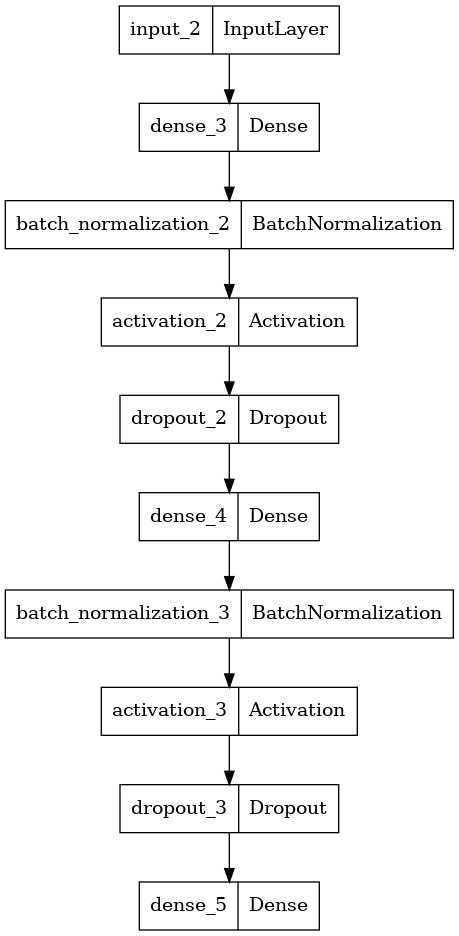

In [16]:
if search:
    STARTING_LAYER_SIZE = best_hps['STARTING_LAYER_SIZE']
    dropout = [best_hps['dropout1'],best_hps['dropout2']]
    DROPOUTS_len= 2#best_hps['dropouts_len']
    hp_activation=best_hps['hp_activation']
    hp_learning_rate=best_hps['hp_learning_rate']
    hp_optimizer=best_hps['optimizer']
else:
    #0.7616174221038818
    STARTING_LAYER_SIZE = 1426#1024
    dropout = [0.3,0.3]
    DROPOUTS_len= 2#3
    hp_activation='relu'#'gelu'
    hp_learning_rate=0.000333#LEARNING_RATE
    hp_optimizer='adam'#'adam'
    
    
if hp_optimizer == 'lion':
        optimizer = Lion(hp_learning_rate)
elif hp_optimizer == 'adam':
    optimizer = tf.keras.optimizers.Adam(hp_learning_rate)    
    
def get_model(n_labels=250, init_fc=STARTING_LAYER_SIZE, flat_frame_len=FLAT_FRAME_SHAPE):
    _inputs = tf.keras.layers.Input(shape=(flat_frame_len,))
    x = _inputs

    # Define layers

    for i in range(DROPOUTS_len):
        x = fc_block(
            x, output_channels=init_fc//(2**i), 
            dropout=dropout[i]
        )
    # Define output layer
    _outputs = tf.keras.layers.Dense(n_labels, activation="softmax")(x)

    # Build the model
    model = tf.keras.models.Model(inputs=_inputs, outputs=_outputs)
    return model

model = get_model()
model.compile(optimizer, "sparse_categorical_crossentropy", metrics="acc")
model.summary()
tf.keras.utils.plot_model(model)

In [17]:
if_train=False
import gc
gc.collect()
folds=[0,1,2,3,4]
models=[]
for fold in folds:
    print(f"Fold {fold}:")
    cb_list = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(patience=LR_PATIENCE, factor=LR_REDUCTION_FACTOR, verbose=1)]
    for i, (train_index, test_index) in enumerate(skf.split(train_x,train_y)):
        if i==fold:
            val_x_fold, val_y_fold = train_x[test_index], train_y[test_index]
            train_x_fold, train_y_fold = train_x[train_index], train_y[train_index]
        
    model = get_model()
    if hp_optimizer == 'lion':
        optimizer = Lion(hp_learning_rate)
    elif hp_optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(hp_learning_rate)    
    model.compile(optimizer, "sparse_categorical_crossentropy", metrics="acc")
    #model.summary()
    #tf.keras.utils.plot_model(model)
    if if_train:
        history = model.fit(train_x_fold, train_y_fold, validation_data=(val_x_fold, val_y_fold), epochs=EPOCHS, callbacks=cb_list, batch_size=BATCH_SIZE)#
    else:
        model = tf.keras.models.load_model(f'/kaggle/input/gislr-tf-on-the-shoulders-kerastunerversion14/models/asl_model_{fold}')#The models are trained in https://www.kaggle.com/code/aikhmelnytskyy/gislr-tf-on-the-shoulders-ensamble?scriptVersionId=121543912
        model.evaluate(val_x_fold, val_y_fold)
    model.save(f"./models/asl_model_{fold}")
    
    #model.evaluate(val_x_fold, val_y_fold)
    #for x,y in zip(val_x_fold[:10], val_y_fold[:10]):
    #    print(f"PRED: {decoder(np.argmax(model.predict(tf.expand_dims(x, axis=0), verbose=0), axis=-1)[0]):<20} – GT: {decoder(y)}")
    models.append(model)
    gc.collect()

Fold 0:
591/591 [==============================] - 4s 3ms/step - loss: 1.0884 - acc: 0.7410
Fold 1:
591/591 [==============================] - 3s 4ms/step - loss: 1.0752 - acc: 0.7453
Fold 2:
591/591 [==============================] - 2s 3ms/step - loss: 1.0413 - acc: 0.7458
Fold 3:
591/591 [==============================] - 2s 3ms/step - loss: 1.0578 - acc: 0.7470
Fold 4:
591/591 [==============================] - 3s 4ms/step - loss: 1.0835 - acc: 0.7399


In [18]:
#model=build_model(best_hps) 
#model=get_model()


In [19]:
#We train the model from scratch, please note that if you have trained enough epochs of the model during meshing, this step can be replaced by
#model = tuner.get_best_models(num_models=1)[0]


In [20]:
#DEFINE A MODEL FUNCTION AND HYPERPARAMETERS
class EpochPrintCB(tf.keras.callbacks.Callback):
    def __init__(self, n_epochs_btwn_prints=5, extra_metrics_to_incl=None):
        self.n_epochs_btwn_prints=n_epochs_btwn_prints        
        self.extra_metrics_to_incl = extra_metrics_to_incl if ((extra_metrics_to_incl is None) or (type(extra_metrics_to_incl)==list)) else list(extra_metrics_to_incl)
    
    def on_epoch_end(self, epoch, logs):
        if epoch % self.n_epochs_btwn_prints == 0:
            print_str = f"|| Epoch {epoch:>3} | lr: {self.model.optimizer.lr.numpy():10.7f} || loss:{logs['loss']:8.5f} | acc:{logs['acc']:8.5f} || val_loss:{logs['val_loss']:8.5f} | val_acc:{logs['val_acc']:8.5f} ||"
            if self.extra_metrics_to_incl is not None:
                for extra_metric in self.extra_metrics_to_incl:
                        print_str = "||".join([
                            group if i in [0, 1, len(print_str.split("||"))-1] else group[:-1]+f" | {'val_' if group[1]=='v' else ''}{extra_metric}:{logs[('val_' if group[1]=='v' else '')+extra_metric]:8.5f} "
                            for i, group in enumerate(print_str.split("||"))
                        ])
            print(print_str)

def fc_block(inputs, output_channels, dropout=0.2, _act="relu"):
    x = tf.keras.layers.Dense(output_channels)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(_act)(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    return x

def get_model(n_labels=250, init_fc=512, n_blocks=2, _dropout_1=0.2, _dropout_2=0.6, _fc_step_rate=2, n_ax=2, n_feats=2,
              types_to_use=("lips", "left_hand", "pose", "right_hand"), do_L1=False, do_L2=False,
              type_frame_len={"lips":43, "left_hand":21, "pose":33, "right_hand":21}):
    
    flat_frame_len = sum([type_frame_len[x]*n_ax*n_feats for x in types_to_use])
    _inputs = tf.keras.layers.Input(shape=(flat_frame_len,))
    x = _inputs
    
    # Define layers
    for i in range(n_blocks):
        x = fc_block(
            x, output_channels=init_fc//(_fc_step_rate**i),
            dropout=_dropout_1 if i!=(n_blocks-1) else _dropout_2
        )
    
    # Define output layers
    _outputs = tf.keras.layers.Dense(n_labels, activation="softmax")(x)
    
    # Build the model
    model = tf.keras.models.Model(inputs=_inputs, outputs=_outputs)
    return model

BATCH_SIZE   = 2048
LR           = 0.0005
DROPOUT_1    = 0.3
DROPOUT_2    = 0.5
N_EPOCHS     = 400
INIT_FC      = 512
N_BLOCKS     = 2
FC_STEP_RATE = 1.25
CB_MONITOR   = "val_acc"
LOSS_FN      = "sparse_categorical_crossentropy"
METRICS      = ["acc", tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='t5_acc')]

model_kwargs =dict(
    init_fc=INIT_FC, 
    n_blocks=N_BLOCKS, 
    _dropout_1=DROPOUT_1, 
    _dropout_2=DROPOUT_2, 
    _fc_step_rate=FC_STEP_RATE,
)

In [21]:
del train_x,train_y
gc.collect()

23

In [22]:
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold
NP_FILE_DIR      = "/kaggle/input/isolated-sign-language-aggregation-preparation"
all_x = np.load(os.path.join(NP_FILE_DIR, "feature_data.npy")).astype(np.float32)
all_y = np.load(os.path.join(NP_FILE_DIR, "feature_labels.npy")).astype(np.uint8)

# add nan back in not to screw up means/std
all_x = np.where(all_x==0.0, np.nan, all_x)

# Get mean and std ignoring nans
all_mean = np.nanmean(all_x, keepdims=True, axis=0)
all_std = np.nanstd(all_x, keepdims=True, axis=0)

# Standardize around 0
all_x = (all_x-all_mean)/all_std
# Technically I don't need to do the were because np.nan 
# subtracting or dividing anything still results in np.nan
#    - all_x = np.where(np.isnan(all_x), all_x, all_x-all_mean)
#    - all_x = np.where(np.isnan(all_x), all_x, all_x/all_std)

# Back to 0s
all_x = np.nan_to_num(all_x)

# There are 21 participants so we use 7 folds
#    --> i.e. 3 participants in val every time
N_PARTICIPANTS = train_df.participant_id.nunique()

# Thanks Robert Hatch! 
#     --> https://www.kaggle.com/competitions/asl-signs/discussion/392335
#
# We are including 29302 in RH signer
RH_SIGNERS = [26734, 28656, 25571, 62590, 29302, 
                       49445, 53618, 18796,  4718,  2044, 
                       37779, 30680]

# We are including 37055 in LH Signer
LH_SIGNERS  = [16069, 32319, 36257, 22343, 27610, 61333, 34503, 55372, 37055]

# Since the sign label itself if relatively 
# There are 21 participants so we use 7 folds
#    --> i.e. 3 participants in val every time
K_FOLDS = 7

def get_folds(df, k_folds, force_one_lh=False, lh_signers=LH_SIGNERS[:-1]):
    while True:
        sgkf = StratifiedGroupKFold(n_splits=K_FOLDS, shuffle=True)
        _fold_ds_idx_map = {
            i:{"train":t_idxs, "val":v_idxs} \
            for i, (t_idxs, v_idxs) in enumerate(sgkf.split(df.index, df.sign, df.participant_id))
        }
        
        # Ensure only one left hander in every val group
        if force_one_lh:
            if all([len(set(df.iloc[_idxs['val']]["participant_id"].unique()).intersection(set(lh_signers)))==1 for _idxs in _fold_ds_idx_map.values()]):
                return _fold_ds_idx_map
            else:
                print(".", end="")
        else:
            return _fold_ds_idx_map
    
fold_ds_idx_map = get_folds(train_df, K_FOLDS)
print(" APPROPRIATE KFOLD SPLIT FOUND!\n")

 APPROPRIATE KFOLD SPLIT FOUND!



In [23]:
histories, MODEL_DIR = [], "/kaggle/working/models1"
if not os.path.isdir(MODEL_DIR): os.makedirs(MODEL_DIR)

for fold_num, fold_idxs in fold_ds_idx_map.items():    
    print(f"\n\n... STARTING TRAINING FOR FOLD #{fold_num+1} ...\n")
    
    # Get the dataset
    val_x, val_y     = all_x[fold_idxs["val"]],   all_y[fold_idxs["val"]]
    train_x, train_y = all_x[fold_idxs["train"]], all_y[fold_idxs["train"]]

    # Initialize optimizer
    optimizer = tf.keras.optimizers.Adam(LR)
    
    # Initialize CB list
    _pct_to_drop = 3
    cb_list = [
        tf.keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True, verbose=1, monitor=CB_MONITOR),
        tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=(1-0.01*_pct_to_drop), verbose=0, monitor=CB_MONITOR),
        EpochPrintCB(extra_metrics_to_incl=["t5_acc",])
    ]
            
    # Initialize model
    model = get_model(**model_kwargs)
    model.compile(optimizer, loss=LOSS_FN, metrics=METRICS)
    
    # See the structure and number of parameters
    if fold_num==0: print(f"\n\nFIRST FOLD... PRINTING MODEL SUMMARY:\n"); model.summary()
        
    # Fit!
    print("\n\n... BEGINNING MODEL TRAINING ...\n")
    if if_train:
        histories.append(model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=N_EPOCHS, callbacks=cb_list, batch_size=BATCH_SIZE, verbose=0))
    
    else:
        model = tf.keras.models.load_model(f'/kaggle/input/gislr-how-to-ensemble-version9/results/models/islr_model__fold_0{fold_num+1}')#The models are trained in version 14
    
    # Save
    model.save(os.path.join(MODEL_DIR, f"islr_model__fold_{fold_num+1:>02}__{model.evaluate(val_x, val_y, verbose=0)[1]:.5f}").replace("0.", ""))
    
    # Cleanup 
    del model, train_x, train_y, val_x, val_y; gc.collect(); gc.collect();



... STARTING TRAINING FOR FOLD #1 ...



FIRST FOLD... PRINTING MODEL SUMMARY:

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 472)]             0         
                                                                 
 dense_21 (Dense)            (None, 512)               242176    
                                                                 
 batch_normalization_14 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 activation_14 (Activation)  (None, 512)               0         
                                                                 
 dropout_14 (Dropout)        (None, 512)               0         
                                                                 
 dense_22 (Dense)            (None, 409)   

In [24]:
#CREATE THE PREPROCESSING FUNCTION
def dumb_tf_mean(x, axis=None):
    return tf.math.reduce_mean(x, axis=axis)

def dumb_tf_std(x, axis=None):
    x = tf.experimental.numpy.var(x, axis=axis, dtype=tf.float32, ddof=1)
    return tf.experimental.numpy.sqrt(x)

class PrepInputs(tf.keras.layers.Layer):
    def __init__(self, lh_idx_range=(468, 489), pose_idx_range=(489, 522), rh_idx_range=(522, 543), distribution_mean=all_mean, distribution_std=all_std):
        super(PrepInputs, self).__init__()
        self.lips = tf.constant([61, 185, 40, 39, 37, 0, 267, 269, 270, 409, 291, 146, 91, 181, 84, 17, 314, 405, 321, 375, 291, 78, 191, 80, 81, 82, 13, 312, 311, 310, 415, 308, 78, 95, 88, 178, 87, 14, 317, 402, 318, 324, 308])
        self.idx_ranges = [lh_idx_range, pose_idx_range, rh_idx_range]
        self.flat_feat_lens = [2*self.lips.shape[0],]+[2*(_range[1]-_range[0]) for _range in self.idx_ranges]
        self.distribution_mean = tf.constant(distribution_mean, dtype=tf.float32)
        self.distribution_std  = tf.constant(distribution_std, dtype=tf.float32)
    
    def call(self, x_in):
        
        # Split the single vector into 4
        xs = [tf.gather(x_in[..., :2], self.lips, axis=1),]+[x_in[:, _range[0]:_range[1], :2] for _range in self.idx_ranges]
        
        # Reshape based on specific number of keypoints
        xs = [tf.reshape(_x, (-1, flat_feat_len)) for _x, flat_feat_len in zip(xs, self.flat_feat_lens)]
        
        # Drop empty rows - Empty rows are present in 
        #   --> face, lh, rh
        #   --> so we don't have to for face
        xs = [tf.boolean_mask(_x, tf.reduce_all(tf.logical_not(tf.math.is_nan(_x)), axis=1), axis=0) for _x in xs]
        
        # Get means and stds
        x_means = [dumb_tf_mean(_x, axis=0) for _x in xs]
        x_stds  = [dumb_tf_std(_x,  axis=0) for _x in xs]
        
        x_out = tf.concat([*x_means, *x_stds], axis=0)
        x_out = tf.expand_dims(tf.where(tf.math.is_nan(x_out), tf.zeros_like(x_out), x_out), axis=0)
        x_out = self.standardize_tensor(x_out)
        return x_out
    
    def standardize_tensor(self, tensor):
        return tf.where(tensor!=0, (tensor-self.distribution_mean)/self.distribution_std, tf.zeros_like(tensor))
    
p_demo = PrepInputs()(load_relevant_data_subset(train_df.path[0]))
print(p_demo.shape)
def dumb_tf_mean(x, axis=None):
    return tf.math.reduce_mean(x, axis=axis)

def dumb_tf_std(x, axis=None):
    x = tf.experimental.numpy.var(x, axis=axis, dtype=tf.float32, ddof=1)
    return tf.experimental.numpy.sqrt(x)

class PrepInputs(tf.keras.layers.Layer):
    def __init__(self, lh_idx_range=(468, 489), pose_idx_range=(489, 522), rh_idx_range=(522, 543), distribution_mean=all_mean, distribution_std=all_std):
        super(PrepInputs, self).__init__()
        self.lips = tf.constant([61, 185, 40, 39, 37, 0, 267, 269, 270, 409, 291, 146, 91, 181, 84, 17, 314, 405, 321, 375, 291, 78, 191, 80, 81, 82, 13, 312, 311, 310, 415, 308, 78, 95, 88, 178, 87, 14, 317, 402, 318, 324, 308])
        self.idx_ranges = [lh_idx_range, pose_idx_range, rh_idx_range]
        self.flat_feat_lens = [2*self.lips.shape[0],]+[2*(_range[1]-_range[0]) for _range in self.idx_ranges]
        self.distribution_mean = tf.constant(distribution_mean, dtype=tf.float32)
        self.distribution_std  = tf.constant(distribution_std, dtype=tf.float32)
    
    def call(self, x_in):
        
        # Split the single vector into 4
        xs = [tf.gather(x_in[..., :2], self.lips, axis=1),]+[x_in[:, _range[0]:_range[1], :2] for _range in self.idx_ranges]
        
        # Reshape based on specific number of keypoints
        xs = [tf.reshape(_x, (-1, flat_feat_len)) for _x, flat_feat_len in zip(xs, self.flat_feat_lens)]
        
        # Drop empty rows - Empty rows are present in 
        #   --> face, lh, rh
        #   --> so we don't have to for face
        xs = [tf.boolean_mask(_x, tf.reduce_all(tf.logical_not(tf.math.is_nan(_x)), axis=1), axis=0) for _x in xs]
        
        # Get means and stds
        x_means = [dumb_tf_mean(_x, axis=0) for _x in xs]
        x_stds  = [dumb_tf_std(_x,  axis=0) for _x in xs]
        
        x_out = tf.concat([*x_means, *x_stds], axis=0)
        x_out = tf.expand_dims(tf.where(tf.math.is_nan(x_out), tf.zeros_like(x_out), x_out), axis=0)
        x_out = self.standardize_tensor(x_out)
        return x_out
    
    def standardize_tensor(self, tensor):
        return tf.where(tensor!=0, (tensor-self.distribution_mean)/self.distribution_std, tf.zeros_like(tensor))
    
p_demo = PrepInputs()(load_relevant_data_subset(train_df.path[0]))
print(p_demo.shape)

(1, 472)
(1, 472)


In [25]:
MODEL_PATHS = sorted(glob(os.path.join(MODEL_DIR, "*")), key=lambda x: int(x.rsplit("__", 1)[-1]), reverse=True)

class ISLRModel(tf.keras.Model):
    """
    TensorFlow Lite model that takes input tensors and applies:
        – a preprocessing model
        – the ISLR model 
    """

    def __init__(self, islr_fold_models):
        """
        Initializes the TFLiteModel with the specified preprocessing model and ISLR model.
        """
        super(ISLRModel, self).__init__()

        # Load the feature generation and main models
        self.islr_fold_models  = list(islr_fold_models.values())
        self.model_weights = tf.repeat(tf.expand_dims(tf.constant([float(k)/100_000. for k in islr_fold_models.keys()], dtype=tf.float32), axis=-1), 250, axis=-1)
    
    def __call__(self, inputs, training=None):
        """
        Applies the feature generation model and main model to the input tensors.

        Args:
            inputs: Input tensor with shape [batch_size, 543, 3].

        Returns:
            A dictionary with a single key 'outputs' and corresponding output tensor.
        """
        batch_size = tf.shape(inputs)[0]
        outputs    = tf.concat([_model(inputs, training=training) for _model in self.islr_fold_models], axis=0)
        outputs = tf.reduce_mean(outputs, axis=0, keepdims=True)

        ### Compute the weighted sum and the sum of the weights and compute the weighted mean
        #outputs    = tf.stack([_model(inputs, training=training) for _model in self.islr_fold_models], axis=1)
        #outputs = tf.reduce_sum(tf.multiply(outputs, tf.repeat(tf.expand_dims(self.model_weights, axis=0), batch_size, axis=0)), axis=1)
        #outputs = tf.divide(outputs, tf.reduce_sum(tf.repeat(tf.expand_dims(self.model_weights, axis=0), batch_size, axis=0), axis=1))
        
        # Return a dictionary with the output tensor
        return outputs

class TFLiteModel(tf.Module):
    """
    TensorFlow Lite model that takes input tensors and applies:
        – a preprocessing model
        – the ISLR model 
    """

    def __init__(self, islr_fold_models, islr_fold_pp_fn):
        """
        Initializes the TFLiteModel with the specified preprocessing model and ISLR model.
        """
        super(TFLiteModel, self).__init__()

        # Load the feature generation and main models
        self.prep_inputs = islr_fold_pp_fn()
        self.islr_fold_models  = list(islr_fold_models.values())
        self.model_weights = tf.repeat(tf.expand_dims(tf.constant([float(k)/100_000. for k in islr_fold_models.keys()], dtype=tf.float32), axis=-1), 250, axis=-1)
    
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, 543, 3], dtype=tf.float32, name='inputs')])
    def __call__(self, inputs):
        """
        Applies the feature generation model and main model to the input tensors.

        Args:
            inputs: Input tensor with shape [batch_size, 543, 3].

        Returns:
            A dictionary with a single key 'outputs' and corresponding output tensor.
        """
        x = self.prep_inputs(tf.cast(inputs, dtype=tf.float32))
        outputs  = tf.concat([_model(x) for _model in self.islr_fold_models], axis=0)
        
        # Compute the weighted sum and the sum of the weights and compute the weighted mean
        outputs = tf.reduce_sum(tf.multiply(outputs, self.model_weights), axis=0)
        outputs = tf.divide(outputs, tf.reduce_sum(self.model_weights, axis=0))
        
        # Return a dictionary with the output tensor
        return {'outputs': outputs}

ISLR_FOLD_MODELS = {_path.rsplit("__", 1)[-1]:tf.keras.models.load_model(_path, compile=False) for _path in MODEL_PATHS}
tflite_keras_model = TFLiteModel(ISLR_FOLD_MODELS, PrepInputs)
out = tflite_keras_model(load_relevant_data_subset(train_df.path[0]))["outputs"]
np.argmax(out)

25

In [26]:
def get_input_shape(num_frames, landmarks, flag_drop_z):
    input_shape = (num_frames, landmarks * 3)

    if flag_drop_z:
        num_coords = 2
    else:
        num_coords = 3

    return (num_frames, landmarks * num_coords)

output_bias = tf.keras.initializers.Constant(1.0 / 250.0)
class MSD(tf.keras.layers.Layer):
    def __init__(
        self,
        units,
        fold_num=1,
        **kwargs,
    ):
        super().__init__(**kwargs)

        self.lin = tf.keras.layers.Dense(
            units,
            activation=None,
            use_bias=True,
            bias_initializer=output_bias,
            # kernel_regularizer=R.l2(WEIGHT_REGULARIZE)
        )

        rate_dropout = 0.5
        self.dropouts = [
            tf.keras.layers.Dropout((rate_dropout - 0.2), seed=135 + fold_num),
            tf.keras.layers.Dropout((rate_dropout - 0.1), seed=690 + fold_num),
            tf.keras.layers.Dropout((rate_dropout), seed=275 + fold_num),
            tf.keras.layers.Dropout((rate_dropout + 0.1), seed=348 + fold_num),
            tf.keras.layers.Dropout((rate_dropout + 0.2), seed=861 + fold_num),
        ]

    def call(self, inputs):
        for ii, drop in enumerate(self.dropouts):
            if ii == 0:
                out = self.lin(drop(inputs)) / 5.0
            else:
                out += self.lin(drop(inputs)) / 5.0
        return out


class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, units, dropout):
        super().__init__()
        self.linear = tf.keras.layers.Dense(units)
        self.bn = tf.keras.layers.BatchNormalization()
        self.act = tf.keras.layers.Activation("gelu")
        if dropout != 0:
            self.drop = tf.keras.layers.Dropout(dropout)
            self.flag_use_drop = True
        else:
            self.flag_use_drop = False

    def call(self, x):
        x = self.linear(x)
        x = self.bn(x)
        x = self.act(x)
        if self.flag_use_drop:
            x = self.drop(x)
        return x

class GRUModel(tf.keras.layers.Layer):
    def __init__(self, units, dropout, num_blocks):
        super().__init__()
        self.start_gru = tf.keras.layers.GRU(
            units=units, dropout=0.0, return_sequences=True
        )
        self.end_gru = tf.keras.layers.GRU(
            units=units, dropout=dropout, return_sequences=False
        )

        if (num_blocks - 2) > 0:
            self.gru_blocks = [
                tf.keras.layers.GRU(units=units, dropout=dropout, return_sequences=True)
                * (num_blocks - 2)
            ]
            self.flag_use_gru_blocks = True
        else:
            self.flag_use_gru_blocks = False

    def call(self, x):
        x = self.start_gru(x)
        if self.flag_use_gru_blocks:
            for blk in self.gru_blocks:
                x = blk(x)
        x = self.end_gru(x)
        return x

def model_utils(cfg, fold_num):
    metric_ls = [
        tf.keras.metrics.SparseCategoricalAccuracy(),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5),
    ]

    cb_list = [
        tf.keras.callbacks.EarlyStopping(
            patience=5,
            restore_best_weights=True,
            verbose=1,
            monitor=cfg["TARGET_METRIC"],
        ),
        tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.8, verbose=1),
        tf.keras.callbacks.ModelCheckpoint(
            f"{SAVE_DIR}/best_acc_{fold_num}.h5",
            monitor=cfg["TARGET_METRIC"],
            verbose=0,
            save_best_only=True,
            save_weights_only=True,
            mode="max",
            save_freq="epoch",
        ),
    ]

    if cfg["FLAG_WANDB"]:
        cb_list += [#WandbMetricsLogger()
            WandbCallback(
                monitor=cfg["TARGET_METRIC"],
                log_weights=False,
                log_evaluation=False,
                save_model=False,
            )
        ]

    opt = tfa.optimizers.AdamW(weight_decay=0, learning_rate=cfg["LR"])
    # opt = tf.keras.optimizers.Adam(learning_rate=LR)
    # opt = tfa.optimizers.RectifiedAdam(learning_rate=LR)
    # opt = tfa.optimizers.Lookahead(opt, sync_period=5)

    return metric_ls, cb_list, opt

# Analyzing Handedness
left_handed_signer = [16069, 32319, 36257, 22343, 27610, 61333, 34503, 55372, 37055]  # both_hands_signer-> 37055
right_handed_signer = [26734, 28656, 25571, 62590, 29302, 49445, 53618, 18796, 4718, 2044, 37779, 30680,]
lip_landmarks = [61, 185, 40, 39, 37, 0, 267, 269, 270, 409, 291, 146, 91, 181, 84, 17, 314, 405, 321, 375, 78, 191, 80, 81, 82, 13, 312, 311, 310, 415, 95, 88, 178, 87, 14, 317, 402, 318, 324, 308]

di = {}
for k in left_handed_signer:
    di[k] = 0
for k in right_handed_signer:
    di[k] = 1

left_hand_landmarks = list(range(468, 468 + 21))
right_hand_landmarks = list(range(522, 522 + 21))

averaging_sets = [
    [0, 468],
    [489, 33],
]  ## average over the entire face, and the entire 'pose'

point_landmarks = [
    item
    for sublist in [lip_landmarks, left_hand_landmarks, right_hand_landmarks]
    for item in sublist
]

LANDMARKS = len(point_landmarks) #+ len(averaging_sets)

# Fixed  ##################################################################################

FLAG_DROP_Z = False
ROWS_PER_FRAME = 543
NUM_FRAMES = 15
INPUT_SHAPE = get_input_shape(NUM_FRAMES, LANDMARKS, FLAG_DROP_Z)
SEGMENTS = 3
NUM_BASE_FEATS = (SEGMENTS + 1) * INPUT_SHAPE[1] * 2
FLAT_FRAME_SHAPE = NUM_BASE_FEATS + (INPUT_SHAPE[0] * INPUT_SHAPE[1])
decoder = {v: k for k, v in read_json_file("/kaggle/input/asl-signs/sign_to_prediction_index_map.json").items()}

    
_inputs = tf.keras.layers.Input(shape=(FLAT_FRAME_SHAPE,))

# import ipdb
# ipdb.set_trace()
x = _inputs[:, :NUM_BASE_FEATS]
x_conv = tf.reshape(_inputs[:, NUM_BASE_FEATS:], (-1, NUM_FRAMES, INPUT_SHAPE[1]))

# Concat Dilated Convolutions with actual data
gru_out = GRUModel(512, 0.5, 1)(x_conv)
x = gru_out

# Residual Block
x = ResidualBlock(1024, 0.25)(x)
x += ResidualBlock(1024, 0.0)(x)

# Final output MSD Layer
x = MSD(units=250)(x)
_outputs = tf.keras.layers.Softmax(dtype="float32")(x)

# Build the model
gwg_models=[]
for i in range(3):
    gwg_model = tf.keras.models.Model(inputs=_inputs, outputs=_outputs)
    gwg_model.summary()
    gwg_model.load_weights(f"/kaggle/input/islr-external-3-my/models/best_acc_{i}.h5")
    gwg_models.append(gwg_model)

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 5658)]       0           []                               
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 3690)        0           ['input_15[0][0]']               
 icingOpLambda)                                                                                   
                                                                                                  
 tf.reshape (TFOpLambda)        (None, 15, 246)      0           ['tf.__operators__.getitem_1[0][0
                                                                 ]']                              
                                                                                           

In [27]:
def tf_nan_mean(x, axis=0):
    return tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), x), axis=axis) / tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), tf.ones_like(x)), axis=axis)

def tf_nan_std(x, axis=0):
    d = x - tf_nan_mean(x, axis=axis)
    return tf.math.sqrt(tf_nan_mean(d * d, axis=axis))

def flatten_means_and_stds(x, axis=0):
    # Get means and stds
    x_mean = tf_nan_mean(x, axis=0)
    x_std  = tf_nan_std(x,  axis=0)

    x_out = tf.concat([x_mean, x_std], axis=0)
    x_out = tf.reshape(x_out, (1, INPUT_SHAPE[1]*2))
    x_out = tf.where(tf.math.is_finite(x_out), x_out, tf.zeros_like(x_out))
    return x_out

class FeatureGen_1(tf.keras.layers.Layer):
    def __init__(self):
        super(FeatureGen_1, self).__init__()
    
    def call(self, x_in):
        x = tf.gather(x_in, point_landmarks, axis=1)

        x_padded = x
        for i in range(SEGMENTS):
            p0 = tf.where( ((tf.shape(x_padded)[0] % SEGMENTS) > 0) & ((i % 2) != 0) , 1, 0)
            p1 = tf.where( ((tf.shape(x_padded)[0] % SEGMENTS) > 0) & ((i % 2) == 0) , 1, 0)
            paddings = [[p0, p1], [0, 0], [0, 0]]
            x_padded = tf.pad(x_padded, paddings, mode="SYMMETRIC")
        x_list = tf.split(x_padded, SEGMENTS)
        x_list = [flatten_means_and_stds(_x, axis=0) for _x in x_list]

        x_list.append(flatten_means_and_stds(x, axis=0))
        
        ## Resize only dimension 0. Resize can't handle nan, so replace nan with that dimension's avg value to reduce impact.
        x = tf.image.resize(tf.where(tf.math.is_finite(x), x, tf_nan_mean(x, axis=0)), [NUM_FRAMES, LANDMARKS])
        x = tf.reshape(x, (1, INPUT_SHAPE[0]*INPUT_SHAPE[1]))
        x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)
        x_list.append(x)
        x = tf.concat(x_list, axis=1)
        return x

In [28]:
ROWS_PER_FRAME = 543
LANDMARK_IDX = [0,9,11,13,14,17,117,118,119,199,346,347,348] + list(range(468,543))
ltsm_model = tf.keras.models.load_model('/kaggle/input/sign-language-classification-2idat/lstm.h5')

In [29]:
DROP_Z2 = False

NUM_FRAMES2 = 15
SEGMENTS2 = 3

LEFT_HAND_OFFSET2 = 468
POSE_OFFSET2 = LEFT_HAND_OFFSET2 + 21
RIGHT_HAND_OFFSET2 = POSE_OFFSET2 + 33

## average over the entire face, and the entire 'pose'
averaging_sets2 = [[0, 468], [POSE_OFFSET2, 33]]

lip_landmarks2 = [
    61,
    185,
    40,
    39,
    37,
    0,
    267,
    269,
    270,
    409,
    291,
    146,
    91,
    181,
    84,
    17,
    314,
    405,
    321,
    375,
    78,
    191,
    80,
    81,
    82,
    13,
    312,
    311,
    310,
    415,
    95,
    88,
    178,
    87,
    14,
    317,
    402,
    318,
    324,
    308,
]
left_hand_landmarks2 = list(range(LEFT_HAND_OFFSET2, LEFT_HAND_OFFSET2 + 21))
right_hand_landmarks2 = list(range(RIGHT_HAND_OFFSET2, RIGHT_HAND_OFFSET2 + 21))

point_landmarks2 = [
    item
    for sublist in [lip_landmarks2, left_hand_landmarks2, right_hand_landmarks2]
    for item in sublist
]

LANDMARKS2 = len(point_landmarks2) + len(averaging_sets2)
print(LANDMARKS)
if DROP_Z2:
    INPUT_SHAPE2 = (NUM_FRAMES2, LANDMARKS2 * 2)
else:
    INPUT_SHAPE2 = (NUM_FRAMES2, LANDMARKS2 * 3)

FLAT_INPUT_SHAPE2 = (INPUT_SHAPE2[0] + 2 * (SEGMENTS2 + 1)) * INPUT_SHAPE2[1]

def flatten_means_and_stds2(x, axis=0):
    # Get means and stds
    x_mean = tf_nan_mean(x, axis=0)
    x_std = tf_nan_std(x, axis=0)

    x_out = tf.concat([x_mean, x_std], axis=0)
    x_out = tf.reshape(x_out, (1, INPUT_SHAPE2[1] * 2))
    x_out = tf.where(tf.math.is_finite(x_out), x_out, tf.zeros_like(x_out))
    return x_out

class FeatureGenTF(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def call(self, x_in):
        if DROP_Z:
            x_in = x_in[:, :, 0:2]
        x_list = [
            tf.expand_dims(
                tf_nan_mean(x_in[:, av_set[0] : av_set[0] + av_set[1], :], axis=1),
                axis=1,
            )
            for av_set in averaging_sets
        ]
        x_list.append(tf.gather(x_in, point_landmarks, axis=1))
        x = tf.concat(x_list, 1)

        x_padded = x
        for i in range(SEGMENTS2):
            p0 = tf.where(
                ((tf.shape(x_padded)[0] % SEGMENTS2) > 0) & ((i % 2) != 0), 1, 0
            )
            p1 = tf.where(
                ((tf.shape(x_padded)[0] % SEGMENTS2) > 0) & ((i % 2) == 0), 1, 0
            )
            paddings = [[p0, p1], [0, 0], [0, 0]]
            x_padded = tf.pad(x_padded, paddings, mode="SYMMETRIC")
        x_list = tf.split(x_padded, SEGMENTS2)
        x_list = [flatten_means_and_stds2(_x, axis=0) for _x in x_list]

        x_list.append(flatten_means_and_stds2(x, axis=0))

        ## Resize only dimension 0. Resize can't handle nan, so replace nan with that dimension's avg value to reduce impact.
        x = tf.image.resize(
            tf.where(tf.math.is_finite(x), x, tf_nan_mean(x, axis=0)),
            [NUM_FRAMES2, LANDMARKS2],
        )
        x = tf.reshape(x, (1, INPUT_SHAPE2[0] * INPUT_SHAPE2[1]))
        x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)
        x_list.append(x)
        x = tf.concat(x_list, axis=1)
        return x

82


# Generate TFLite Model and submission.zip

In [30]:
class TFLiteModel(tf.Module):
    """
    TensorFlow Lite model that takes input tensors and applies:
        – a preprocessing model
        – the ISLR model 
    """

    def __init__(self, islr_fold_models, islr_fold_pp_fn, gwg_model, gwg_pp_fn, asl_models, ltsm_model, ASLInferModel):
        """
        Initializes the TFLiteModel with the specified preprocessing model and ISLR model.
        """
        super(TFLiteModel, self).__init__()

        # Load the feature generation and main models
        self.prep_inputs_1 = islr_fold_pp_fn()
        self.prep_inputs_2 = gwg_pp_fn()
        self.models_1      = list(islr_fold_models.values())
        self.models_2       = gwg_models
        self.prep_inputs = FeatureGen()
        self.asl_models   = asl_models
        self.ltsm_model   = ltsm_model
        self.feature_gen = FeatureGenTF()
        self.ASLInferModel = tf.saved_model.load(ASLInferModel)
        self.feature_gen.trainable = False
        self.ASLInferModel.trainable = False
    
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, 543, 3], dtype=tf.float32, name='inputs')])
    def __call__(self, inputs):
        """
        Applies the feature generation model and main model to the input tensors.

        Args:
            inputs: Input tensor with shape [batch_size, 543, 3].

        Returns:
            A dictionary with a single key 'outputs' and corresponding output tensor.
        """
        x = self.prep_inputs(tf.cast(inputs, dtype=tf.float32))
        outputs=[]
        for asl_model in self.asl_models:
            outputs.append(asl_model(x)[0, :])
        outputs_3 = tf.keras.layers.Average()(outputs)
        
        
        x1 = self.prep_inputs_1(tf.cast(inputs, dtype=tf.float32))
        x2 = self.prep_inputs_2(tf.cast(inputs, dtype=tf.float32))
        
        outputs_1 = tf.keras.layers.Average()([_model(x1) for _model in self.models_1])
        
        outputs_2=[]
        for gwg_model in self.models_2:
            outputs_2.append(gwg_model(x2))
        outputs_2 = tf.keras.layers.Average()(outputs_2)
        
        # 2x weighting higher score via repeat 14
        outputs = tf.multiply(0.25, outputs_1)+tf.multiply(0.45, outputs_2)+tf.multiply(0.3, outputs_3)
        
        x_ltsm = tf.gather(inputs, LANDMARK_IDX, axis=1)

        # fill nan
        x_ltsm = tf.where(tf.math.is_nan(x_ltsm), tf.zeros_like(x_ltsm), x_ltsm)

        # flatten landmark xyz coordinates ()
        x_ltsm = tf.concat([x_ltsm[...,i] for i in range(3)], -1)

        x_ltsm = tf.expand_dims(x_ltsm,0)

        # call trained model
        out_x_ltsm = self.ltsm_model(x_ltsm)
        
        outputs = tf.multiply(0.70, outputs)+tf.multiply(0.30, out_x_ltsm)
        
        
        features = self.feature_gen(tf.cast(inputs, dtype=tf.float32))

        outputs_5 = self.ASLInferModel(**{"input": features})["output"][0, :]
        
        outputs = tf.multiply(0.95, outputs)+tf.multiply(0.05, outputs_5)
        
        # Return a dictionary with the output tensor
        return {'outputs': outputs}
    
ISLR_FOLD_MODELS = {_path.rsplit("__", 1)[-1]:tf.keras.models.load_model(_path, compile=False) for _path in MODEL_PATHS}
tflite_keras_model = TFLiteModel(ISLR_FOLD_MODELS, PrepInputs, gwg_models, FeatureGen_1,models[2:3], ltsm_model, '/kaggle/input/asl-sign-detection-pytorch-lightning/tf_model')
out = tflite_keras_model(load_relevant_data_subset(train_df.path[0]))["outputs"]
np.argmax(out)

25

As you can see, our ensemble includes the following models:
* ISLR_FOLD_MODELS -https://www.kaggle.com/code/dschettler8845/gislr-how-to-ensemble
* gwg_models - https://www.kaggle.com/code/dschettler8845/gislr-how-to-ensemble
* my models - https://www.kaggle.com/code/aikhmelnytskyy/gislr-tf-on-the-shoulders-ensamble?scriptVersionId=121543912
* ltsm_model - https://www.kaggle.com/code/aleksandrkruchinin/tflite-ensemble

In [31]:
!pip install tflite-runtime
import tflite_runtime.interpreter as tflite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 26.0 MB/s eta 0:00:00a 0:00:01


In [32]:
keras_model_converter = tf.lite.TFLiteConverter.from_keras_model(tflite_keras_model)
keras_model_converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = keras_model_converter.convert()
with open('/kaggle/working/models/model.tflite', 'wb') as f:
    f.write(tflite_model)
!zip submission.zip /kaggle/working/models/model.tflite

interpreter = tflite.Interpreter("/kaggle/working/models/model.tflite")
found_signatures = list(interpreter.get_signature_list().keys())
# if REQUIRED_SIGNATURE not in found_signatures:
#     raise KernelEvalException('Required input signature not found.')
prediction_fn = interpreter.get_signature_runner("serving_default")

output = prediction_fn(inputs=load_relevant_data_subset(train_df.path[0]))
sign = np.argmax(output["outputs"])

print("PRED : ", decoder[sign])
print("GT   : ", train_df.sign[0])

  adding: kaggle/working/models/model.tflite (deflated 37%)
PRED :  blow
GT   :  blow
